# 转置卷积

转置卷积
- 卷积不会增大输入的高宽，通常要么不变，要么减半
- 转置卷积可以用来增大输入高宽

为什么称之为“转置”
- 对于卷积Y = X * W
  - 可以对W构造一个V，使得卷积等价于矩阵乘法Y'= VX'
  - 这里Y'、X'是X，Y对应的向量版本
- 转置卷积等价于Y'= V^TX'
- 如果卷积将输入从(h, w)变成了(h',w')
  - 同样超参数的转置卷积则从(h',w')变回(h, w)

转置卷积
- 转置卷积是一种卷积
  - 它将输入和核进行了重新排列
  - 同卷积一般是做下采样不同，它通常采用上采样
  - 如果卷积将输入从(h,w)变成了(h',w'),同样超参数下它将(h',w')变成(h,w)

重新排列输入和核
- 当填充为0，步幅为1时
  - 将输入填充k-1(k是核窗口)
  - 将核矩阵上下、左右翻转
  - 然后做正常卷积(填充为0、步幅为1)

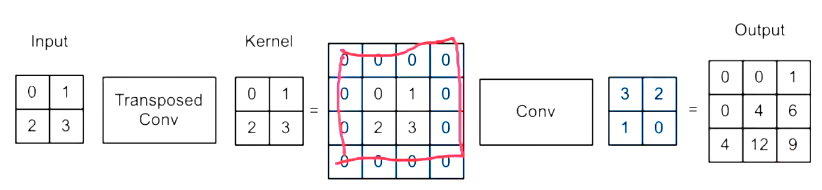

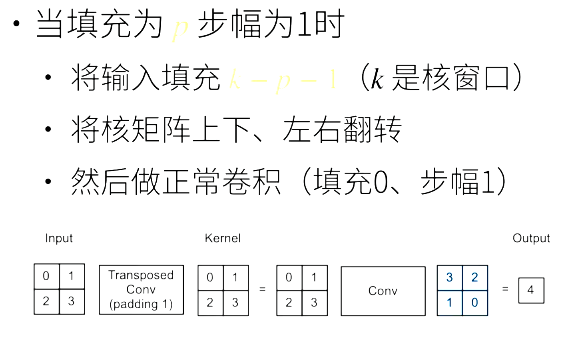

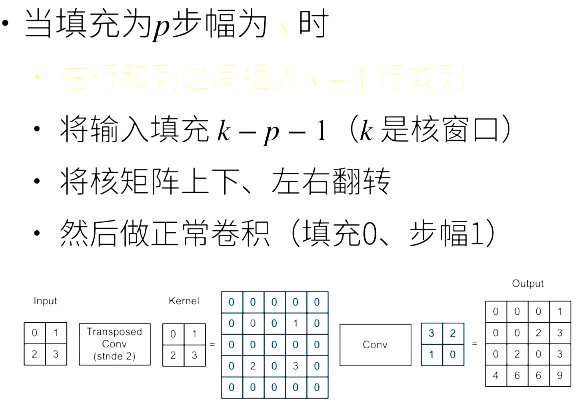

总结
- 转置卷积是一种变化了输入和核的卷积，来得到上采样的目的
- 不同于数学中的反卷积运算

In [1]:
#导入第三方库
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
#基本操作
#对输入矩阵X和卷积核矩阵K实现基本的转置卷积运算trans_conv
def trans_conv(X, K):
    """实现转置卷积运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j:j + w] += X[i, j] * K
    return Y

In [5]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

In [8]:
#当X或Y都是4维张量时，调用高级API完成相同操作 
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias= False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

In [9]:
#填充、步幅和多通道
#在转置卷积中，填充被用于输出
#当将高和宽两侧的填充数指定为1时，转置卷积的输出中将删除第一和最后的行与列。
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding= 1, bias= False)
tconv.weight.data = K
tconv(X) 

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

In [11]:
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride= 2, bias= False)
tconv.weight.data = K
tconv(X) 

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

In [12]:
#多个通道的情况
X = torch.rand(size=(1, 10, 16, 16))
conv = nn.Conv2d(10, 20, kernel_size= 5, padding= 2, stride= 3)
tconv = nn.ConvTranspose2d(20, 10, kernel_size= 5, padding= 2,  stride= 3)
tconv(conv(X)).shape == X.shape

True

In [14]:
#与矩阵变换的联系
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
Y

tensor([[27., 37.],
        [57., 67.]])

In [18]:
#将卷积核K重写为包含大量0的稀疏权重矩阵w，权重矩阵的形状为(4,9),其中非0元素来自卷积核K
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

In [20]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([[True, True],
        [True, True]])

In [21]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])